#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import pandas as pd
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=e28533b0-2cea-4ed5-bc38-416cf8ff2904
To: c:\Users\sande\OneDrive\Bureau\EPFL\MA4\Brain-Like\NX-414\Project\IT_data.h5
100%|██████████| 384M/384M [00:32<00:00, 11.6MB/s] 


'IT_data.h5'

In [3]:
try:
    %pip install torchinfo
except:
    print("Couldn't install torchinfo")

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Extra imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchinfo import summary
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the data

In [5]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


## Small visualization of the dataset

In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


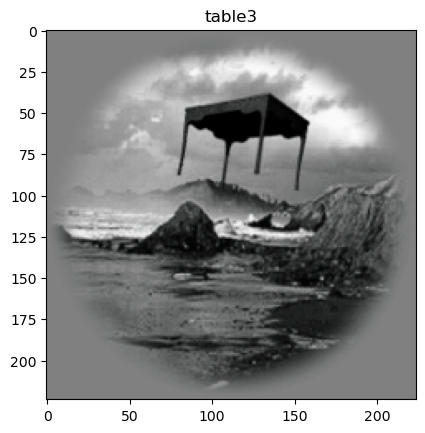

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

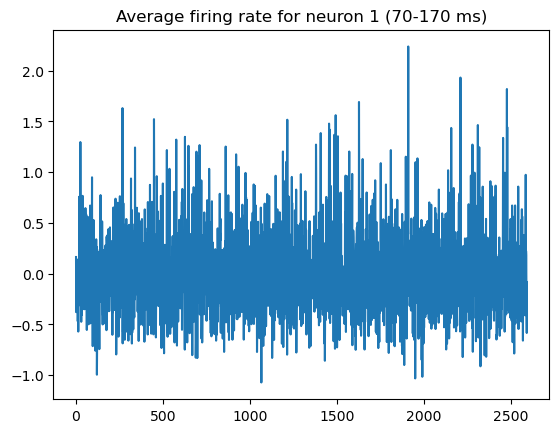

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [ ]:
# Least square linear regression
## Create the model
from sklearn.linear_model import LinearRegression
lsq = LinearRegression()
## Get the data in a 2D shape, of size n_stimulus x (n_channels*img_size*img_size)
X_train = stimulus_train.reshape(n_stimulus,-1)
y_train = spikes_train
## Fit the model
lsq.fit(X_train,y_train)

In [ ]:
# Ridge linear regression
## Create the model
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10, solver='svd')
## Fit the model
ridge.fit(X_train,y_train)


In [ ]:
# Lasso linear regression
## Create the model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
## Fit the model
lasso.fit(X_train,y_train)

In [ ]:
# ElasticNet linear regression
## Create the model
from sklearn.linear_model import ElasticNet    
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
## Fit the model
elastic.fit(X_train,y_train)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [18]:
# Define the two evaluation metrics
## Pearson correlation
def pearson_correlation(y_true, y_pred):
      n_neurons = y_true.shape[1]
      corrs = np.zeros(n_neurons)
      for i in range(n_neurons):
            corrs[i] = pearsonr(y_true[:, i], y_pred[:, i])[0]
      return corrs

## Explained variance
def R_squared(y_true, y_pred):
      n_neurons = y_true.shape[1]
      Rs_squared = np.zeros(n_neurons)
      for i in range(n_neurons):
            SS_tot = np.sum((y_true[:, i] - np.mean(y_true[:, i]))**2)
            SS_res = np.sum((y_true[:, i] - y_pred[:, i])**2)
            Rs_squared[i] = 1 - SS_res/SS_tot
      return Rs_squared

In [ ]:
# Get the evaluation metrics for both models
## Get the predictions
### Ridge
X_val = stimulus_val.reshape(stimulus_val.shape[0],-1)
y_val = spikes_val
y_pred_ridge = ridge.predict(X_val)

### Least squares
y_pred_lsq = lsq.predict(X_val)

### Lasso
y_pred_lasso = lasso.predict(X_val)

### ElasticNet
y_pred_elastic = elastic.predict(X_val)


## Evaluate the models
### Ridge
corrs_ridge = pearson_correlation(y_val,y_pred_ridge)
Rs_ridge = R_squared(y_val,y_pred_ridge)

### Least squares
corrs_lsq = pearson_correlation(y_val,y_pred_lsq)
Rs_lsq = R_squared(y_val,y_pred_lsq)

### Lasso
corrs_lasso = pearson_correlation(y_val,y_pred_lasso)
Rs_lasso = R_squared(y_val,y_pred_lasso)

### ElasticNet
corrs_elastic = pearson_correlation(y_val,y_pred_elastic)
Rs_elastic = R_squared(y_val,y_pred_elastic)

In [ ]:
# Plot both metrics for all neurons for all linear regressions
corrs = [corrs_ridge, corrs_lsq, corrs_lasso, corrs_elastic]
Rs_squared = [Rs_ridge, Rs_lsq, Rs_lasso, Rs_elastic]
all_metrics = [corrs, Rs_squared]
methods = ['Ridge', 'Least squares', 'Lasso', 'ElasticNet']
metrics = ['Correlation', 'Explained variance']
plt.figure()
for i in range(2):
      for j in range(4):
            plt.subplot(2,4,4*i+j+1)
            plt.plot(all_metrics[i][j])
            if i==0:
                  plt.title(methods[j])
            if i==1:
                  plt.xlabel('Neuron index')
            if j==0:
                  plt.ylabel(metrics[i])
plt.suptitle('Evaluation of the models')
plt.show()

We can indeed see that the models overfit, as the explained variance is negative for all neurons for Ridge and least squares regression, which means that the predictions are worse than just taking some constant mean neural activity as a predictor. Correlations are also extremely low for the validation set, reinforcing the idea that the models are not generalizing well.

In [ ]:
# Get the evaluation metrics for both models on the training set
## Get the predictions
### Ridge
y_pred_ridge_train = ridge.predict(X_train)

### Least squares
y_pred_lsq_train = lsq.predict(X_train)

### Lasso
y_pred_lasso_train = lasso.predict(X_train)

### ElasticNet
y_pred_elastic_train = elastic.predict(X_train)


## Evaluate the models
### Ridge
corrs_ridge_train = pearson_correlation(y_train,y_pred_ridge_train)
Rs_ridge_train = R_squared(y_train,y_pred_ridge_train)

### Least squares
corrs_lsq_train = pearson_correlation(y_train,y_pred_lsq_train)
Rs_lsq_train = R_squared(y_train,y_pred_lsq_train)

### Lasso
corrs_lasso_train = pearson_correlation(y_train,y_pred_lasso_train)
Rs_lasso_train = R_squared(y_train,y_pred_lasso_train)

### ElasticNet
corrs_elastic_train = pearson_correlation(y_train,y_pred_elastic_train)
Rs_elastic_train = R_squared(y_train,y_pred_elastic_train)

In [ ]:
# Plot both metrics for all neurons for all linear regressions
corrs = [corrs_ridge_train, corrs_lsq_train, corrs_lasso_train, corrs_elastic_train]
Rs_squared = [Rs_ridge_train, Rs_lsq_train, Rs_lasso_train, Rs_elastic_train]
all_metrics = [corrs, Rs_squared]
methods = ['Ridge', 'Least squares', 'Lasso', 'ElasticNet']
metrics = ['Correlation', 'Explained variance']
plt.figure()
for i in range(2):
      for j in range(4):
            plt.subplot(2,4,4*i+j+1)
            plt.plot(all_metrics[i][j])
            plt.ylim([-0.05,1.05])
            if i==0:
                  plt.title(methods[j])
            if i==1:
                  plt.xlabel('Neuron index')
            if j==0:
                  plt.ylabel(metrics[i])
plt.suptitle('Evaluation of the models')
plt.show()

Looking at the results on the training set, we can indeed see that there is huge overfitting on the training set, as the explained variance and correlations are of almost 1 for the Ridge and least squares regression models. This overfitting has to be handled somehow, like through what we do in the following sections.

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [ ]:
# Extracting the 1000 PCs

## First flatten the images
X_train = stimulus_train.reshape(n_stimulus,-1)
X_val = stimulus_val.reshape(stimulus_val.shape[0],-1)

## Initialize the PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)

## Fit the PCA and transform the data
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [ ]:
# Run Ridge regression on PCs

## Create the model
ridge_pca = Ridge(alpha=10, solver='svd')

## Fit the model
ridge_pca.fit(X_train_pca,y_train)

## Get the predictions for the validation set
y_pred_pca = ridge_pca.predict(X_val_pca)

In [ ]:
# Evaluating the model and ploting the results

## Evaluate the model
corrs_pca = pearson_correlation(y_val,y_pred_pca)
Rs_pca = R_squared(y_val,y_pred_pca)

## Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(corrs_pca)
plt.ylim([-0.05,1.05])
plt.ylabel('Correlation')
plt.subplot(2,1,2)
plt.plot(Rs_pca)
plt.ylim([-1,1])
plt.xlabel('Neuron index')
plt.ylabel('Explained variance')
plt.suptitle('Evaluation of the model with 1000 PCs')
plt.show()


We see that the results get better. Let's now try to find the optimal value of the regularization parameter for the Ridge regression model.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
# First, we create an iterable object that will return the indexes of the training and validation sets for each fold, respecting the fact that each fold should have the same class distribution
## Create the stratified k-fold object
n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True, random_state=42)
## Create folds' indexes
train_idxs = np.repeat(None, n_folds)
val_idxs = np.repeat(None, n_folds)
for i, (train_idx, val_idx) in enumerate(skf.split(X_train_pca, objects_train)):
      train_idxs[i] = train_idx
      val_idxs[i] = val_idx

In [ ]:
# Getting an approximation of the best alpha
## Create the cross validation object 
ridge_cv = RidgeCV(alphas=np.logspace(0, 9, 10), cv = [(train_idxs[i], val_idxs[i]) for i in range(n_folds)])
## Fit the model
ridge_cv.fit(X_train_pca,y_train)
## See the best alpha
print('The best alpha is {}'.format(ridge_cv.alpha_))

In [ ]:
# Find a better alpha, by looking at a more fine-grained range around the previous best alpha
## Create the cross validation object
ridge_cv = RidgeCV(alphas=np.linspace(1e5, 5e6, 15), cv = [(train_idxs[i], val_idxs[i]) for i in range(n_folds)])
## Fit the model
ridge_cv.fit(X_train_pca,y_train)
## See the best alpha
print('The best alpha is {}'.format(ridge_cv.alpha_))

In [ ]:
# Now that we have our best alpha, it's time to see the performance !
## Create the model
ridge_final = Ridge(alpha=ridge_cv.alpha_, solver='svd')

## Fit the model
ridge_final.fit(X_train_pca,y_train)

## Get the predictions for the validation set
y_pred_final = ridge_final.predict(X_val_pca)

## Evaluate the model
corrs_final = pearson_correlation(y_val,y_pred_final)
Rs_final = R_squared(y_val,y_pred_final)

## Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(corrs_final, label='Final')
plt.plot(corrs_pca, label = 'Untuned')
plt.plot(corrs_ridge, label = 'Without PCA')
plt.ylim([-0.05,1.05])
plt.ylabel('Correlation')
plt.legend()
plt.subplot(2,1,2)
plt.plot(Rs_final, label='Final')
plt.plot(Rs_pca, label = 'Untuned')
plt.plot(Rs_ridge, label = 'Without PCA')
plt.ylim([-2.5,1])
plt.xlabel('Neuron index')
plt.ylabel('Explained variance')
plt.legend()
plt.suptitle('Evaluation of the model with 1000 PCs')
plt.show()


The performance still isn't insanely good, but there is a small increase in correlation and explained variance with respect to the previous models.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [9]:
# Variable to see if we import the PCs or if we run the extraction
importPCs = True

### Subpart 1 : Extracting activations and PCs for each layer

Let's start by loading the model and seeing what it looks like.

In [10]:
# Loading the pretrained ResNet50 model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights = weights, progress = True).to(device)

# As we won't be training the model (it's already pretrained, we just want the activations in the intermediate layers) we can set require_grad to False for all params.
for param in model.parameters():
    param.require_grad = False

# Get a summary of the model
summary(model = model, 
        input_size = [1, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

Now that we know what the model looks like, let's code some helper functions to extract the PCs of the layers of interest.

In [11]:
# Function to extract and return the activations of some layer of interest
# This function is actually somewhat of a modified forward function that just gets what we need.
def layerActivationExtractor(model, input, layer_name):
    """
    Arguments :
    - model : the ResNet50 model
    - input : the images, of size N_images x H x W
    - layer_name : the name of the layer of interest
    
    Output : activations, ndarray of size N_images x (shape_activations)
    
    Description :
    This function gets the activations for all images for one layer of interest.
    It sequentially passes the input through the layers manually, stopping after the layer of interest to return the activations.
    In order, and thanks to the summary in the previous cell, we know that the input passes through the layers... 
    - conv1
    - bn1
    - relu
    - maxpool
    - layer1
    - layer2
    - layer3
    - layer4
    - avgpool
    - fc
    """
    if layer_name not in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
        raise ValueError("Non-compatible layer name.")
        return None
    
    all_activations = np.repeat(None, input.shape[0])
    for i in range(input.shape[0]):
        # Resize each to the appropriate size of 1 x 3 x 224 x 224
        model_input = input[i].unsqueeze(0)
        # Pass through conv1
        activation = model.conv1(model_input)
        # This is a layer of interest, let's grab the activations
        if layer_name == "conv1":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
            continue

        # Pass through bn1
        activation = model.bn1(activation)
        # Pass through relu
        activation = model.relu(activation)
        # Pass through maxpool
        activation = model.maxpool(activation)

        # Pass through layer1
        activation = model.layer1(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "layer1":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through layer2
        activation = model.layer2(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "layer2":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through layer3
        activation = model.layer3(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "layer3":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through layer4
        activation = model.layer4(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "layer4":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through avgpool
        activation = model.avgpool(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "avgpool":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
    
    # We don't care about the model's actual output, so we don't pass through the final layer.

    return np.stack(all_activations)

# Now, let's make a function to run a PCA and extract the PCs on the extracted activations
def extractPCs(activations_train, activations_val):
    """
    Arguments :
    - activations_train : the train activations array, of size N_images x N_activations
    - activations_val : the validation activations array, of size N_images x N_activations
    
    Output : PCs for the activations tensor, ndarray of size N_images x N_PCs
    
    Description :
    This function extracts the PCs from the activations tensor for both train and test set. 
    We need this to be done together as we want the PCA to be fit on the entire dataset (train + validation)'s activations, 
    not have separate PCAs for train and validation sets. 
    """
    
    # Run a PCA and get the PCs
    n_PCs = 1000
    pca = PCA(n_components = n_PCs)
    pca = pca.fit(np.concatenate(activations_train, activations_val), axis = 0)
    pcs_train = pca.transform(activations_train)
    pcs_val = pca.transform(activations_val)
    
    return [pcs_train, pcs_val]

# Let's make a function that saves the PCs in a CSV file
def savePCs(pcs, filename, pc_folder_path):
    """
    Arguments :
    - pcs : the principle components array, of size N_images x N_PCs
    - filename : the name given to the file we want to save to
    - pc_folder_path : path to the folder what will contain all of the PCs
    
    Output : None
    
    Description :
    This function saves the PCs of some layer into a CSV file.
    The goal of this is to not have to run the activation extraction procedure multiple times, rather only once.
    """
    
    # Define path to csv file
    csv_file_path = pc_folder_path + filename + ".csv"
    
    # Create the csv file for storing the PCs if it doesn't exist yet
    if not os.path.exists(csv_file_path):
        with open(csv_file_path, "w"):
            pass  # This will create an empty file
    
    # Write the activations in
    df = pd.DataFrame(pcs)
    df.to_csv(csv_file_path, index = False, header = False)
    
# Let's make a function that loads the PCs from the csv file
def loadPCs(filename, pc_folder_path):
    """
    Arguments : 
    - filename : the name of the file we want to load the activations from, without .csv extension
    - pc_folder_path : path to the folder what contains all of the PCs
    
    Output : PCs for the layer, ndarray of size N_images x N_PCs
    """
    
    # Define path to csv file
    csv_file_path = pc_folder_path + filename + ".csv"
    
    # Load csv file to a pandas dataframe
    df = pd.read_csv(csv_file_path, header = None)
    
    return df.to_numpy()

We're all set. Let's extract the activations using a for loop!

In [12]:
# Convert stimulus to torch tensor
stimulus_train = torch.from_numpy(stimulus_train).to(device)
stimulus_train.require_grad = False

stimulus_val = torch.from_numpy(stimulus_val).to(device)
stimulus_val.require_grad = False

In [13]:
# Make results folder
pc_folder_path = "results/"
os.makedirs(pc_folder_path, exist_ok=True)

In [14]:
if not importPCs:
    # Extract PCs from activations and save them
    for layer_name in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
        # Get activations
        activations_train = layerActivationExtractor(model, stimulus_train, layer_name) 
        activations_val = layerActivationExtractor(model, stimulus_val, layer_name) 
        # Get PCs
        pcs_train, pcs_val = extractPCs(activations_train, activations_val)
        savePCs(pcs_train, layer_name+"_train", pc_folder_path)
        savePCs(pcs_val, layer_name+"_val", pc_folder_path)
        print(f"Extraction and saving for layer {layer_name} done!")

### Subpart 2 : Use PCs to compute neural activity 

In [15]:
# Helper functions for running regressions and plotting of metrics
def fitRegressions(X_train, y_train):
    # Define all models
    lsq = LinearRegression()
    ridge = Ridge(alpha=10, solver='svd')
    lasso = Lasso(alpha=0.1)
    elastic = ElasticNet(alpha=1.0, l1_ratio=0.5)
    # Fit all models
    lsq.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    lasso.fit(X_train, y_train)
    elastic.fit(X_train, y_train)
    
    return [lsq, ridge, lasso, elastic]

def runRegressions(X_train, y_train, X_val, y_val):
    # Fit all regressions
    models = fitRegressions(X_train, y_train)
    corrs = []
    explVars = []
    for model in models:
        # Make prediction
        y_pred = model.predict(X_val)
        # Compute correlation and explained variance
        corr = pearson_correlation(y_val, y_pred)
        explVar = R_squared(y_val, y_pred)
        # Append to lists
        corrs.append(corr)
        explVars.append(explVar)
    
    return [corrs, explVars]

def plotResults(all_results, method_names, metric_names):
    plt.figure()
    for i in range(2):
        for j in range(4):
            plt.subplot(2,4,4*i+j+1)
            plt.plot(all_results[i][j])
            if i==0:
                plt.title(method_names[j])
            if i==1:
                plt.xlabel('Neuron index')
            if j==0:
                plt.ylabel(metric_names[i])

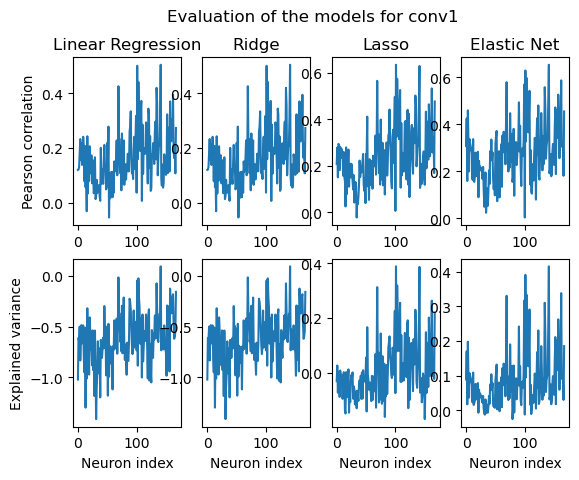

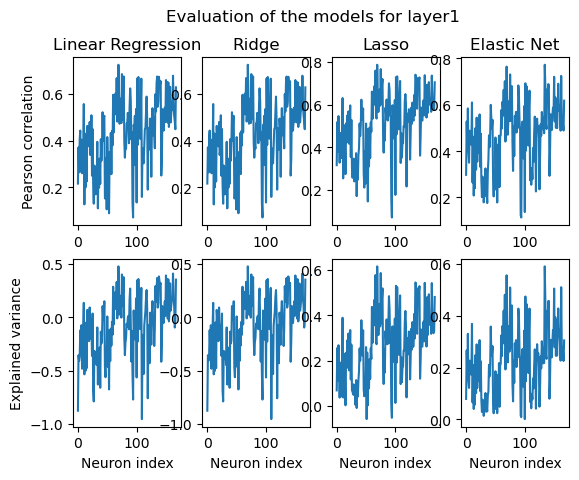

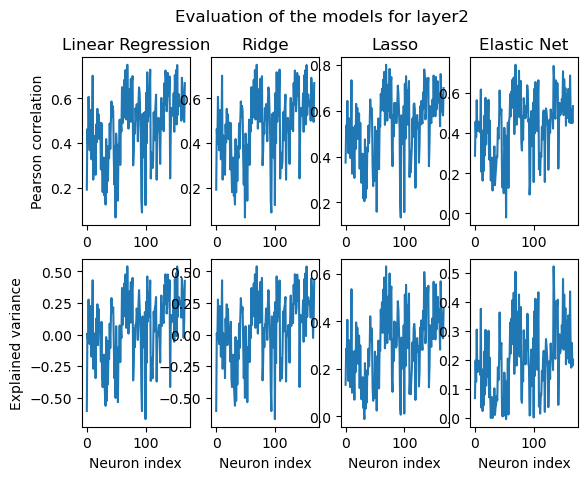

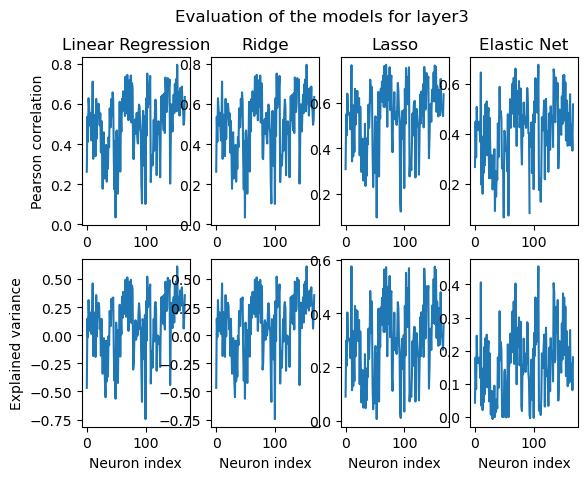

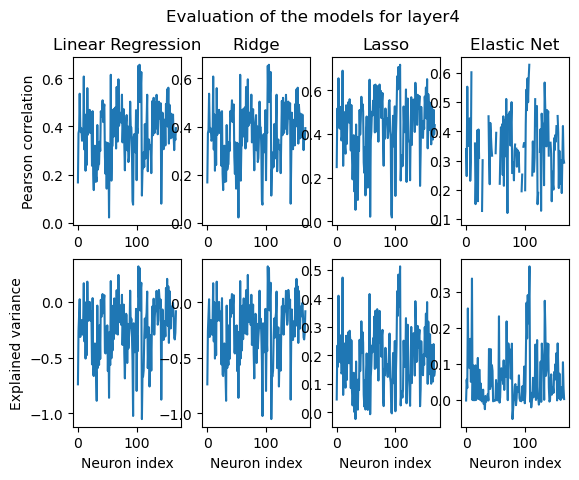

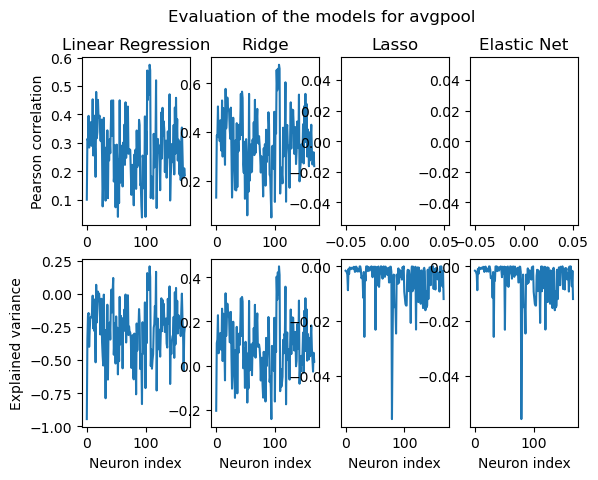

In [19]:
method_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]
metric_names = ["Pearson correlation", "Explained variance"]

all_results = []
for layer_name in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
    # Load the PCs
    PCs_train = loadPCs(layer_name+"_train", pc_folder_path)
    PCs_val = loadPCs(layer_name+"_val", pc_folder_path)
    # Run regressions and get metrics for each
    results = runRegressions(PCs_train, spikes_train, PCs_val, spikes_val)
    all_results.append(results)
    # Plot the results across cells
    plotResults(results, method_names, metric_names)
    plt.suptitle(f'Evaluation of the models for {layer_name}')

plt.show()

In [20]:
# Create pandas dataframe for each layer, containing minimum, maximum, mean and standard deviation of the metrics
df = pd.DataFrame(columns = ['Layer', 'Method', 'Metric', 'Minimum', 'Maximum', 'Mean', 'Standard deviation'])
for i, layer_name in enumerate(["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]):
    for j, method in enumerate(method_names):
        for k, metric in enumerate(metric_names):
            # Get the metric values
            metric_values = all_results[i][k][j]
            # Compute the statistics
            minimum = np.round(np.min(metric_values), 3)
            maximum = np.round(np.max(metric_values), 3)
            mean = np.round(np.mean(metric_values), 3)
            std = np.round(np.std(metric_values), 3)
            # Append to the dataframe
            df = pd.concat([df, pd.DataFrame([{'Layer': layer_name, 'Method': method, 'Metric': metric, 'Minimum': minimum, 'Maximum': maximum, 'Mean': mean, 'Standard deviation': std}])], ignore_index=True)

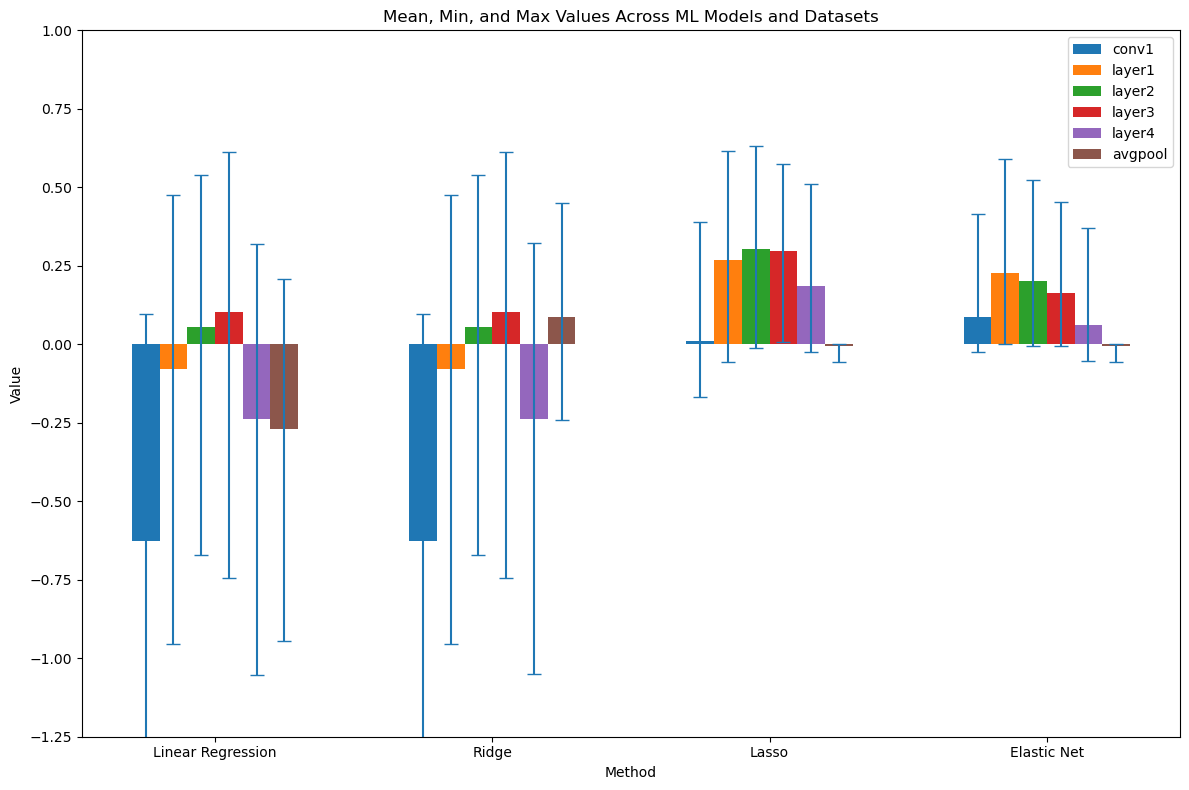

In [38]:
# Get the two dataframes separately
df_corr = df[df['Metric'] == 'Pearson correlation']
df_explVar = df[df['Metric'] == 'Explained variance']

# Get unique layers and methods
layers = df_explVar['Layer'].unique()
methods = df_explVar['Method'].unique()

# Define the figure and axis objects
plt.figure(figsize=(12, 8))

# Plot each combination of method and layer
bar_width = 0.1
index = np.arange(len(methods))

for i, layer in enumerate(layers):
    mean_values = df_explVar[df_explVar['Layer'] == layer]['Mean']
    min_values = df_explVar[df_explVar['Layer'] == layer]['Minimum']
    max_values = df_explVar[df_explVar['Layer'] == layer]['Maximum']
    
    plt.bar(index + i * bar_width, mean_values, bar_width, label=layer)
    plt.errorbar(index + i * bar_width, mean_values, yerr=[mean_values - min_values, max_values - mean_values],
                 fmt='none', capsize=5)

# Add ax limits, labels and title
plt.ylim(-1.25, 1)
plt.xlabel('Method')
plt.ylabel('Value')
plt.title('Mean, Min, and Max Values Across ML Models and Datasets')
plt.xticks(index + bar_width * (len(layers) - 1) / 2, methods)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

The above plot shows the mean, as well as the minimal and maximal values of the explained variance for each layer across neurons. We can see that the explained variance is very variable, and for the first two models increases as the layer gets deeper, consistent with the idea that the deeper layers of the network capture more general features of the image. However, after the 3rd layer, the explained variance decreases, which is consistent with the idea that the deeper layers of the network capture more abstract features of the image, which are not necessarily the ones that are relevant for predicting neural activity. It is worth noting that the mean explained variance is low, but that this is most likely due to the fact that the explained variance is negative for some neurons, which is not possible in practice. Also, the maximal explained variance is of about 0.6, which is not bad at all.

For the third and fourth model, we can see that the mean explained variance is higher, but that they are still relatively poor. We can see the same trend as for the first two models, namely that the mean (and maximal) explained variance first increases and then decreases, again consistent with the two aforementioned ideas. All mean explained variances are higher than 0, which is an improvement with respect to the other two, but still not great.

## Subpart 3 : Running everything for the randomly initialized model

In [22]:
# Loading the ResNet50 model with randomized weights
random_model = resnet50(weights = None, progress = True).to(device)

# To not train the model
for param in random_model.parameters():
    param.require_grad = False

if not importPCs:
    # Extract PCs from activations and save them
    for layer_name in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
        # Get activations
        activations_train = layerActivationExtractor(random_model, stimulus_train, layer_name) 
        activations_val = layerActivationExtractor(random_model, stimulus_val, layer_name) 
        # Get PCs
        pcs_train, pcs_val = extractPCs(activations_train, activations_val)
        savePCs(pcs_train, layer_name+"_random_train", pc_folder_path)
        savePCs(pcs_val, layer_name+"_random_val", pc_folder_path)
        print(f"Extraction and saving for layer {layer_name} done!")

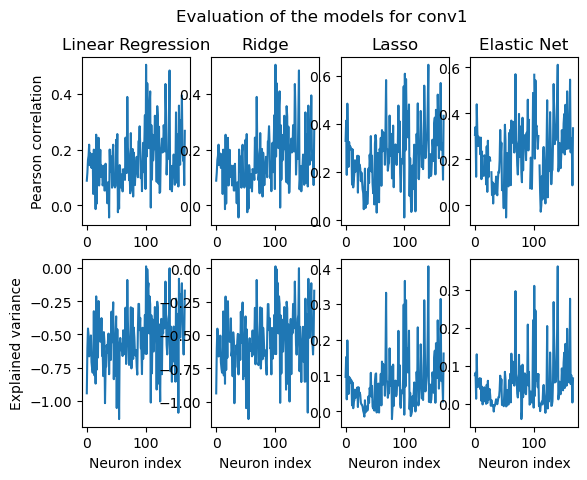

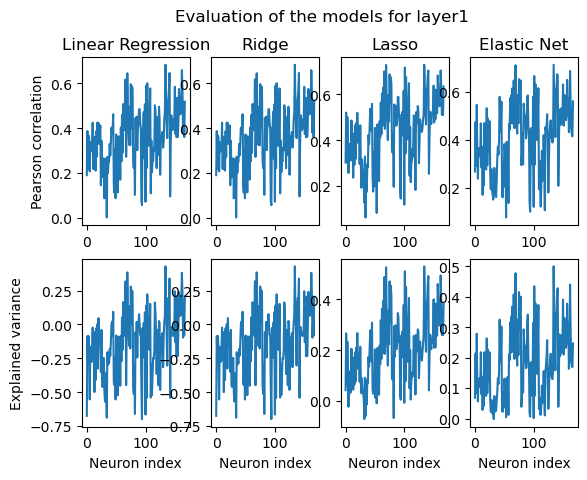

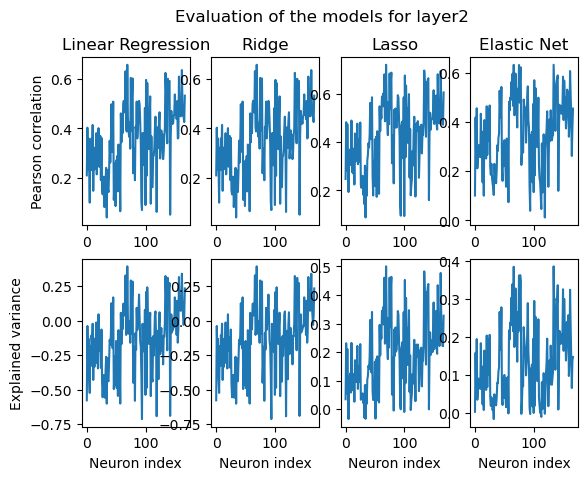

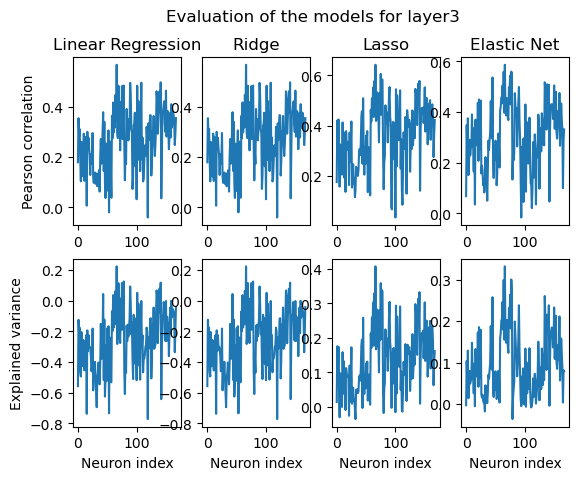

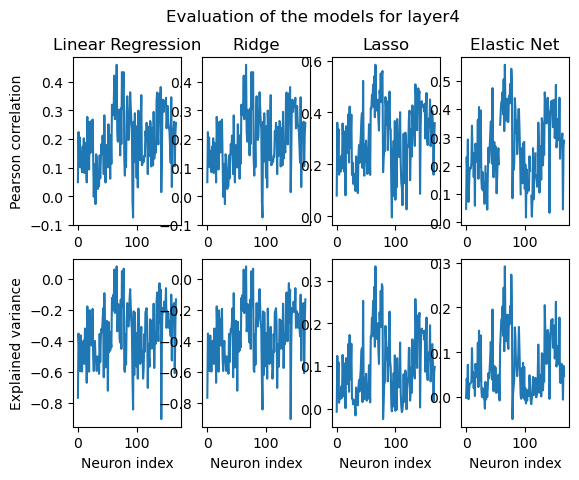

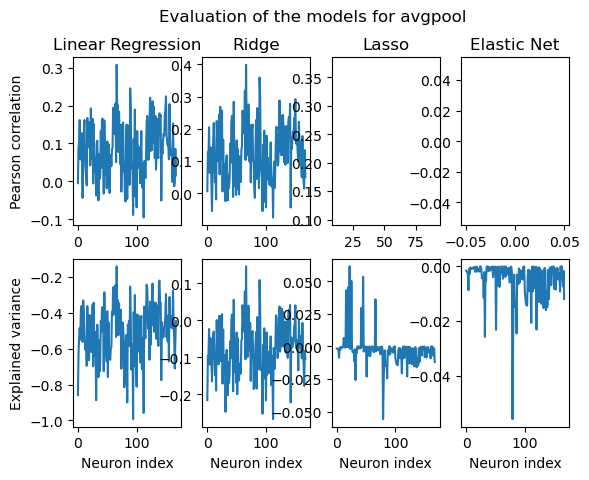

In [23]:
# Load the PCs
all_results_random = []
for layer_name in ["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]:
    # Load the PCs
    PCs_train = loadPCs(layer_name+"_random_train", pc_folder_path)
    PCs_val = loadPCs(layer_name+"_random_val", pc_folder_path)
    # Run regressions and get metrics for each
    results = runRegressions(PCs_train, spikes_train, PCs_val, spikes_val)
    all_results_random.append(results)
    # Plot the results across cells
    plotResults(results, method_names, metric_names)
    plt.suptitle(f'Evaluation of the models for {layer_name}')

plt.show()

In [24]:
# Create pandas dataframe for each layer, containing minimum, maximum, mean and standard deviation of the metrics
df_random = pd.DataFrame(columns = ['Layer', 'Method', 'Metric', 'Minimum', 'Maximum', 'Mean', 'Standard deviation'])
for i, layer_name in enumerate(["conv1", "layer1", "layer2", "layer3", "layer4", "avgpool"]):
    for j, method in enumerate(method_names):
        for k, metric in enumerate(metric_names):
            # Get the metric values
            metric_values = all_results_random[i][k][j]
            # Compute the statistics
            minimum = np.round(np.min(metric_values), 3)
            maximum = np.round(np.max(metric_values), 3)
            mean = np.round(np.mean(metric_values), 3)
            std = np.round(np.std(metric_values), 3)
            # Append to the dataframe
            df_random = pd.concat([df_random, pd.DataFrame([{'Layer': layer_name, 'Method': method, 'Metric': metric, 'Minimum': minimum, 'Maximum': maximum, 'Mean': mean, 'Standard deviation': std}])], ignore_index=True)


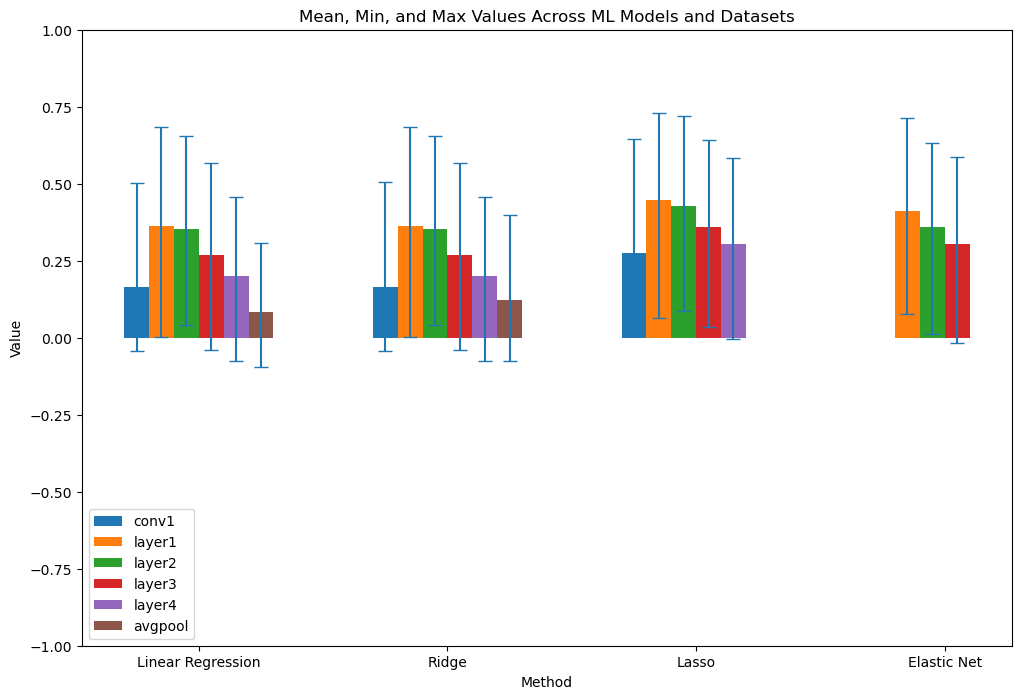

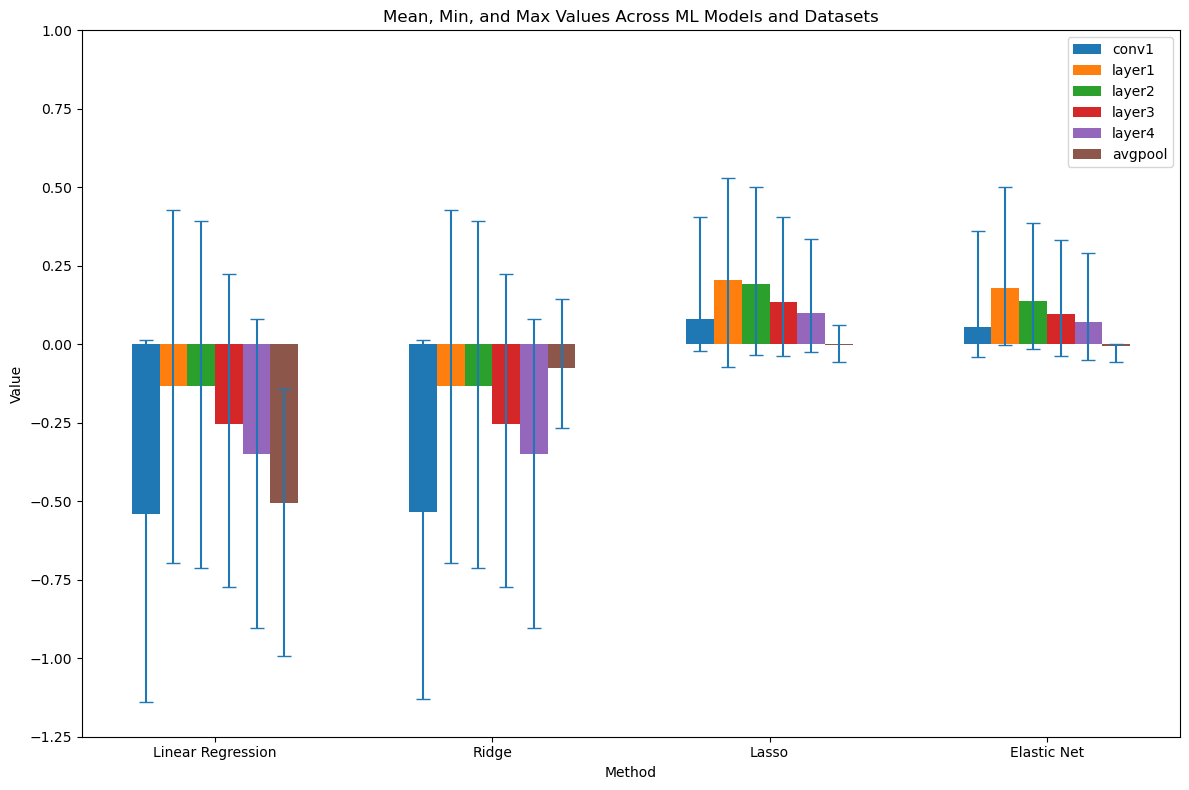

In [37]:
# Get the two dataframes separately
df_corr_random = df_random[df_random['Metric'] == 'Pearson correlation']
df_explVar_random = df_random[df_random['Metric'] == 'Explained variance']

# For the correlation
# Get unique layers and methods
layers = df_corr_random['Layer'].unique()
methods = df_corr_random['Method'].unique()

# Define the figure and axis objects
plt.figure(figsize=(12, 8))

# Plot each combination of method and layer
bar_width = 0.1
index = np.arange(len(methods))

for i, layer in enumerate(layers):
    mean_values = df_corr_random[df_corr_random['Layer'] == layer]['Mean']
    min_values = df_corr_random[df_corr_random['Layer'] == layer]['Minimum']
    max_values = df_corr_random[df_corr_random['Layer'] == layer]['Maximum']
    
    plt.bar(index + i * bar_width, mean_values, bar_width, label=layer)
    plt.errorbar(index + i * bar_width, mean_values, yerr=[mean_values - min_values, max_values - mean_values],
                 fmt='none', capsize=5)

# Add ax limits, labels and title
plt.ylim(-1, 1)
plt.xlabel('Method')
plt.ylabel('Value')
plt.title('Mean, Min, and Max Values Across ML Models and Datasets')
plt.xticks(index + bar_width * (len(layers) - 1) / 2, methods)
plt.legend()

# For the explained variance
# Get unique layers and methods
layers = df_explVar_random['Layer'].unique()
methods = df_explVar_random['Method'].unique()

# Define the figure and axis objects
plt.figure(figsize=(12, 8))

# Plot each combination of method and layer
bar_width = 0.1
index = np.arange(len(methods))

for i, layer in enumerate(layers):
    mean_values = df_explVar_random[df_explVar_random['Layer'] == layer]['Mean']
    min_values = df_explVar_random[df_explVar_random['Layer'] == layer]['Minimum']
    max_values = df_explVar_random[df_explVar_random['Layer'] == layer]['Maximum']
    plt.bar(index + i * bar_width, mean_values, bar_width, label=layer)
    plt.errorbar(index + i * bar_width, mean_values, yerr=[mean_values - min_values, max_values - mean_values],
                 fmt='none', capsize=5)

# Add ax limits, labels and title
plt.ylim(-1.25, 1)
plt.xlabel('Method')
plt.ylabel('Value')
plt.title('Mean, Min, and Max Values Across ML Models and Datasets')
plt.xticks(index + bar_width * (len(layers) - 1) / 2, methods)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In subpart 2 we saw that the performance for the pretrained models weren't great, but compared to the performance of the models with the randomly initialized model, they were much better. the reason why this was the case is that the pretrained models have already learned to extract features that are relevant for the task of classifying images, which is somehow related to neural activity, as in animals decision making and object identification are only possible through neural activity. It therefore makes sense for a network that was already trained on classifying images to be able to better predict neural activity than a randomly initialized network.